In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import random
import networkx as nx
from sklearn import preprocessing
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

### Lectura de imágenes de prueba

In [58]:
path = "../dataset/GCD/train"

In [59]:
image_files = glob.glob(
        os.path.join(path,"**/*.jpg"), recursive=True
    )

In [60]:
random.shuffle(image_files)

In [61]:
MAX_IMAGES = 28
image_files = image_files[:MAX_IMAGES]

In [62]:
targets = [os.path.basename(x).split("_")[1] for x in image_files]

In [63]:
df = pd.DataFrame({"img_path":image_files, "target": targets})

In [64]:
le = preprocessing.LabelEncoder()
df['color']= le.fit_transform(df['target'])

In [65]:
def readImage(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256))
    image = np.array(image)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #C,H,W
    return image

In [66]:
images = np.array([readImage(path) for path in image_files])

In [67]:
images=(images-np.mean(images))/np.std(images)

In [68]:
df['target'].value_counts()

cumulonimbus     9
stratocumulus    8
cumulus          4
clearsky         4
altocumulus      2
cirrus           1
Name: target, dtype: int64

<AxesSubplot:>

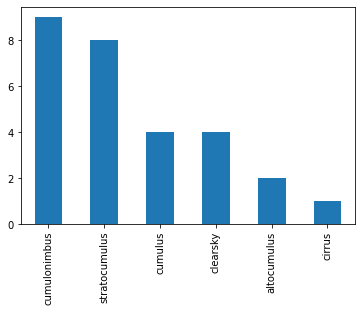

In [69]:
df['target'].value_counts().plot.bar()

### Procesamiento y construcción de matriz de adyacencia

In [70]:
cnn = torch.nn.Sequential(*(list(models.resnet50(pretrained=True).children())[:-1]))

In [71]:
with torch.no_grad():
    features = cnn(torch.tensor(images).float())

In [72]:
features = features.reshape(-1,2048)

In [89]:
THRESHOLD = 0.75

In [73]:
Z_norm = torch.linalg.norm(features, dim=1, keepdim=True)  # Size (n, 1).
similarity = ((features @ features.T) / (Z_norm @ Z_norm.T)).T

#### Construcción de la matriz de adyacencia

In [90]:
adjacency = torch.where(similarity>THRESHOLD, 1, 0)
adjacency

tensor([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [91]:
G = nx.from_numpy_matrix(adjacency.numpy(), create_using=nx.Graph)

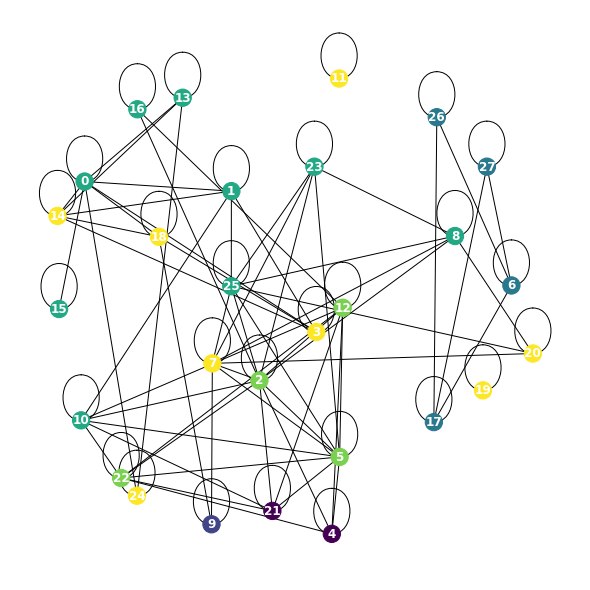

In [92]:
plt.figure(1,figsize=(8,8)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=df['color'], font_color="white", font_weight="bold")
plt.show()

In [79]:
df.iloc[10]['img_path']

'../dataset/GCD/train\\6_cumulonimbus\\6_cumulonimbus_001380.jpg'

In [80]:
df

,img_path,target,color
0,../dataset/GCD/train\6_cumulonimbus\6_cumuloni...,cumulonimbus,3
1,../dataset/GCD/train\6_cumulonimbus\6_cumuloni...,cumulonimbus,3
2,../dataset/GCD/train\1_cumulus\1_cumulus_00004...,cumulus,4
3,../dataset/GCD/train\5_stratocumulus\5_stratoc...,stratocumulus,5
4,../dataset/GCD/train\2_altocumulus\2_altocumul...,altocumulus,0
5,../dataset/GCD/train\1_cumulus\1_cumulus_00026...,cumulus,4
6,../dataset/GCD/train\4_clearsky\4_clearsky_001...,clearsky,2
7,../dataset/GCD/train\5_stratocumulus\5_stratoc...,stratocumulus,5
8,../dataset/GCD/train\6_cumulonimbus\6_cumuloni...,cumulonimbus,3
9,../dataset/GCD/train\3_cirrus\3_cirrus_000022.jpg,cirrus,1


### GAT Conv

In [81]:
from dgl.nn import GATConv

In [82]:
src, dst = np.nonzero(adjacency.numpy())
g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)
g.ndata['feat'] = features
g = g.to("cuda")

In [83]:
gatconv = GATConv(2048, 512, num_heads=1).to("cuda")

In [84]:
gatconv(g, g.ndata['feat']).shape

torch.Size([28, 1, 512])